In [195]:
#第1题 1.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
from netCDF4 import Dataset
file_path = "200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc" 
data = Dataset(file_path)

# 提取变量
methane = data.variables['xch4'][:]  # 甲烷数据
lat = data.variables['lat'][:]  # 纬度
lon = data.variables['lon'][:]  # 经度

# 替换无效值
methane_filtered = np.where(methane == 1.e+20, np.nan, methane)


methane_ppb = methane_filtered * 1e9

# 按月份计算月气候学平均
monthly_avg = []
for month in range(12):
    monthly_mean = np.nanmean(methane_ppb[month::12, :, :], axis=0)
    monthly_avg.append(monthly_mean)
monthly_avg = np.array(monthly_avg)  # 转为数组

# 去季节化
deseasonalized = np.zeros_like(methane_ppb)
for t in range(methane_ppb.shape[0]):
    month = t % 12  
    deseasonalized[t, :, :] = methane_ppb[t, :, :] - monthly_avg[month]

# 时间序列
time = pd.date_range(start="2003-01", periods=methane_ppb.shape[0], freq='M')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2732\3054984258.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  methane = data.variables['xch4'][:]  # 甲烷数据
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2732\3054984258.py:25: RuntimeWarning: Mean of empty slice
  monthly_mean = np.nanmean(methane_ppb[month::12, :, :], axis=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2732\3054984258.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time = pd.date_range(start="2003-01", periods=methane_ppb.shape[0], freq='M')


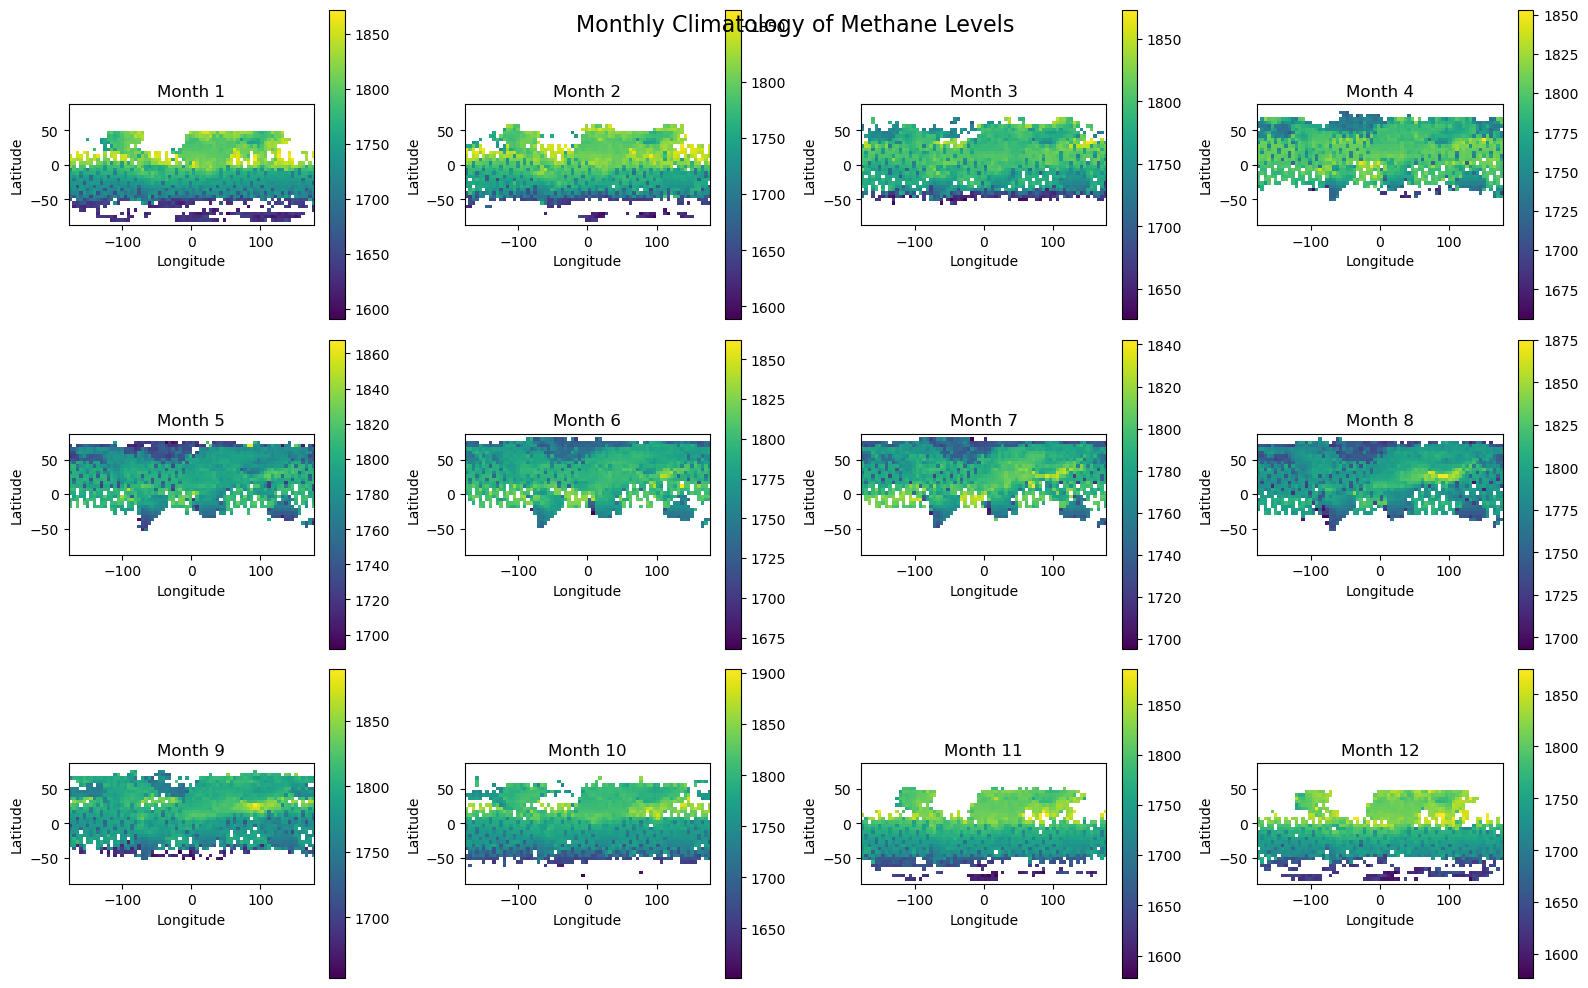

In [73]:
# 绘制每月气候学平均值
fig, axes = plt.subplots(3, 4, figsize=(16, 10), subplot_kw={'projection': None})
for i, ax in enumerate(axes.flat):
    im = ax.imshow(monthly_avg[i], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis')
    ax.set_title(f'Month {i+1}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    fig.colorbar(im, ax=ax, orientation='vertical')
plt.tight_layout()
plt.suptitle('Monthly Climatology of Methane Levels', fontsize=16)
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2732\611914144.py:3: RuntimeWarning: Mean of empty slice
  global_avg = np.nanmean(methane_ppb, axis=(1, 2))


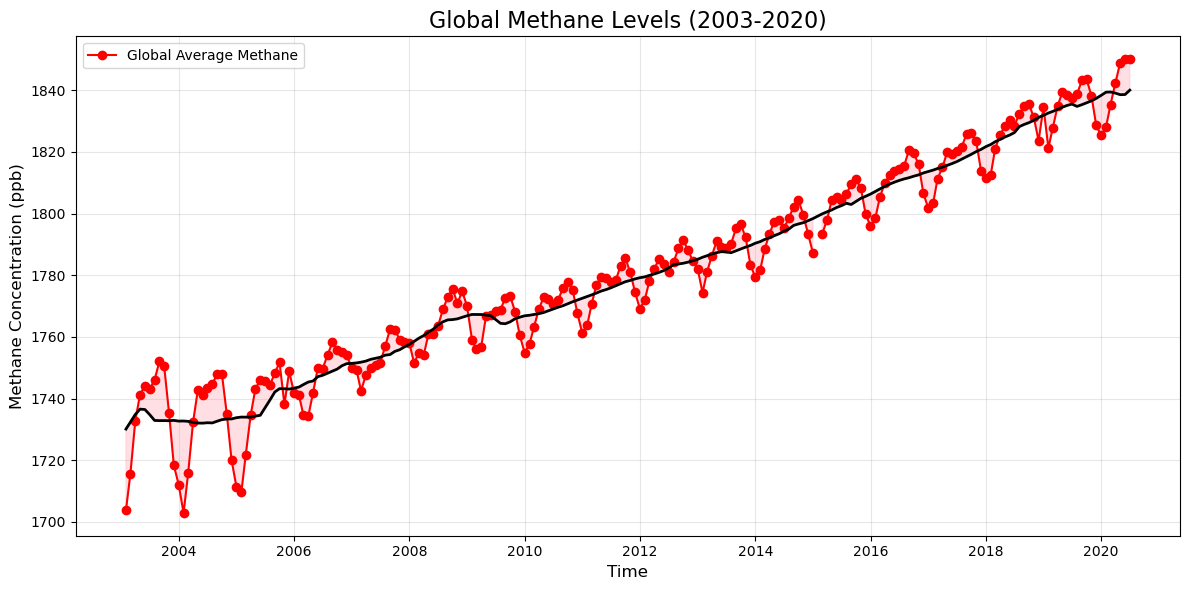

In [197]:
#第1题 1.2
# 计算全球平均值
global_avg = np.nanmean(methane_ppb, axis=(1, 2))
# 平滑趋势线 (用 Pandas 的 rolling 平滑方法覆盖整个范围)
global_avg_series = pd.Series(global_avg)
trend = global_avg_series.rolling(window=12, center=True, min_periods=1).mean()  # 12 个月移动平均


# 绘制时间序列
plt.figure(figsize=(12, 6))
plt.plot(time, global_avg, 'o-', color='red', label='Global Average Methane')
plt.title('Global Methane Levels (2003-2020)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Methane Concentration (ppb)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.fill_between(time, trend, global_avg, color='pink', alpha=0.5, label='Deviation')  # 阴影
plt.plot(time, trend, '-', color='black', linewidth=2, label='Trend')  # 趋势线
plt.show()


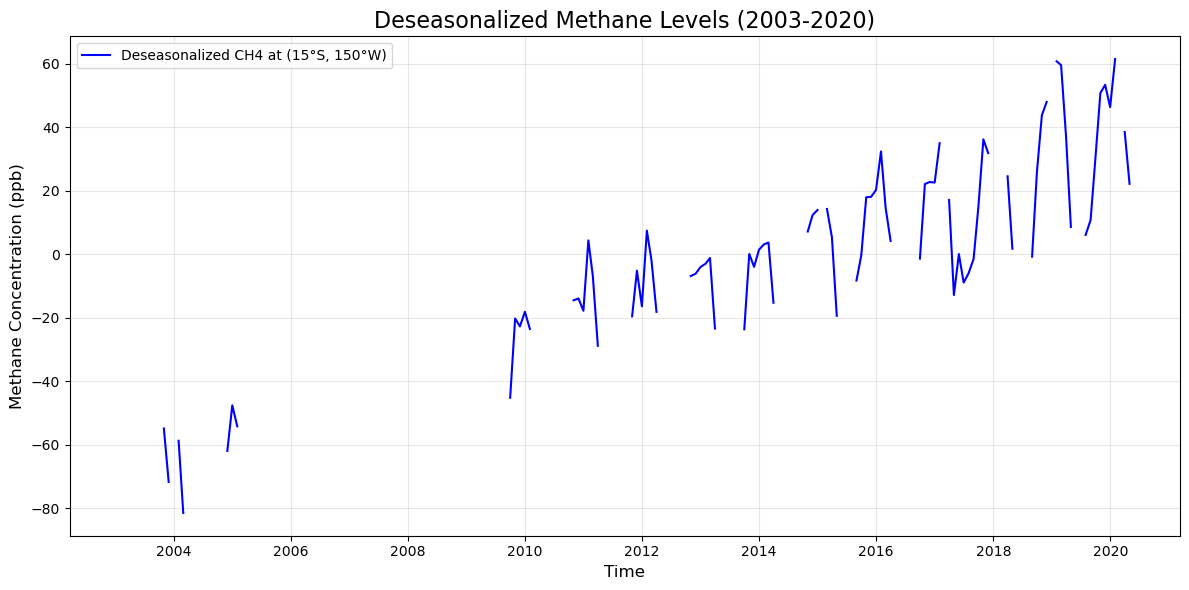

In [199]:
#第1题 1.3
# 提取特定点的数据
lat_idx = np.argmin(np.abs(lat - -15))  # 找到15°S
lon_idx = np.argmin(np.abs(lon - -150))  # 找到150°W
point_data = deseasonalized[:, lat_idx, lon_idx]

# 绘制去季节化时间序列
plt.figure(figsize=(12, 6))
plt.plot(time, point_data, label='Deseasonalized CH4 at (15°S, 150°W)', color='blue')
plt.title('Deseasonalized Methane Levels (2003-2020)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Methane Concentration (ppb)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [201]:
#第2题 2.1
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
# Open a netCDF4 file
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [101]:
dn=ds.sst.sel(lat=slice(-5, 5), lon=slice(190, 240))  #170W-140W换算成360°格式，应该为360-170和360-140，为190°-240°


sst_clim = dn.groupby('time.month').mean()




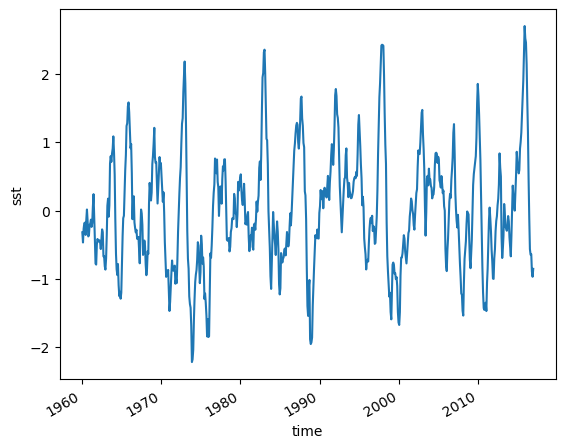

In [107]:


group_data = dn.groupby('time.month')


sst_anom = group_data - group_data.mean(dim='time')
sst_anom

sst_anom.mean(dim=['lat', 'lon']).plot()

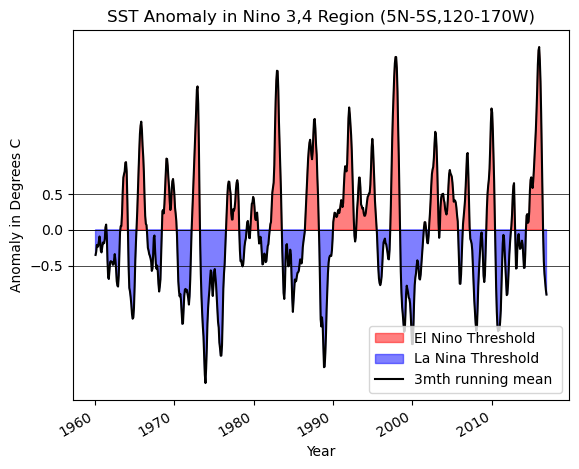

In [203]:

#第2题 2.2
#计算3月滑动平均值
rolling_mean = sst_anom.rolling(time=3, center=True).mean()

#计算全区的滑动平均值的平均值
rolling_mean_values = rolling_mean.mean(dim=['lat', 'lon'])

fig, ax = plt.subplots()

#填充曲线到x轴之间区域
ax.fill_between(rolling_mean.time.values, rolling_mean_values, where=rolling_mean_values >= 0,
                color='red', interpolate=True, alpha=0.5,label='El Nino Threshold')
ax.fill_between(rolling_mean.time.values, rolling_mean_values, where=rolling_mean_values < 0,
                color='blue', interpolate=True, alpha=0.5, label='La Nina Threshold')

#绘制滑动平均曲线
rolling_mean_values.plot(ax=ax,color='black', label='3mth running mean ')

ax.axhline(0, color='black',linewidth=0.5)

# 添加纵坐标网格线
ax.yaxis.grid(True)
ax.yaxis.grid(which='major', color='black', linestyle='-', linewidth=0.5)
ax.set_yticks([-0.5, 0, 0.5])

# 图例设置在右下角
ax.legend(loc='lower right')
plt.title('SST Anomaly in Nino 3,4 Region (5N-5S,120-170W)')
plt.xlabel('Year') 
plt.ylabel('Anomaly in Degrees C')

plt.show()

In [205]:
#第3题 3.1
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 加载 NetCDF 数据
file_path = "CHM_PRE_0.25dg_19612022.nc"  
ds = xr.open_dataset(file_path)
ds




<xarray.Dataset>
Dimensions:         (longitude: 256, latitude: 144, years: 62, time: 22645)
Coordinates:
  * longitude       (longitude) float64 72.12 72.38 72.62 ... 135.4 135.6 135.9
  * latitude        (latitude) float64 18.12 18.38 18.62 ... 53.38 53.62 53.88
  * years           (years) float64 1.961e+03 1.962e+03 ... 2.021e+03 2.022e+03
  * time            (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2022-12-31
Data variables:
    pre             (time, latitude, longitude) float32 ...
    station_number  (years, latitude, longitude) float32 ...
Attributes:
    Title:               IDW + PRISM: China gridded daily precipitation
    Institution:         Data held at Beijing Normal University, China
    History:             Last updated on 30-Apr-2023
    Time scale:          1961-01-01 to 2022-12-31
    Time resolution:     daily
    Spatial extent:      18°N–54°N, 72°E–136°E
    Spatial resolution:  0.25° × 0.25°
    Contact:             miaocy@bnu.edu.cn

In [187]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 加载 NetCDF 数据
file_path = "CHM_PRE_0.25dg_19612022.nc"  # 替换为实际路径
ds = xr.open_dataset(file_path)

# 提取降水变量
precip = ds['pre']

# 数据清洗：去除无效值（假设无效值为 -99 或 NaN）
precip_cleaned = precip.where((precip != -99.9000015258789) & (~np.isnan(precip)), np.nan)
# 获取降水变量的最小值和最大值（清除 NaN 后）
pre_min = precip_cleaned.min().values
pre_max = precip_cleaned.max().values

# print(f"Precipitation range: {pre_min} to {pre_max}")



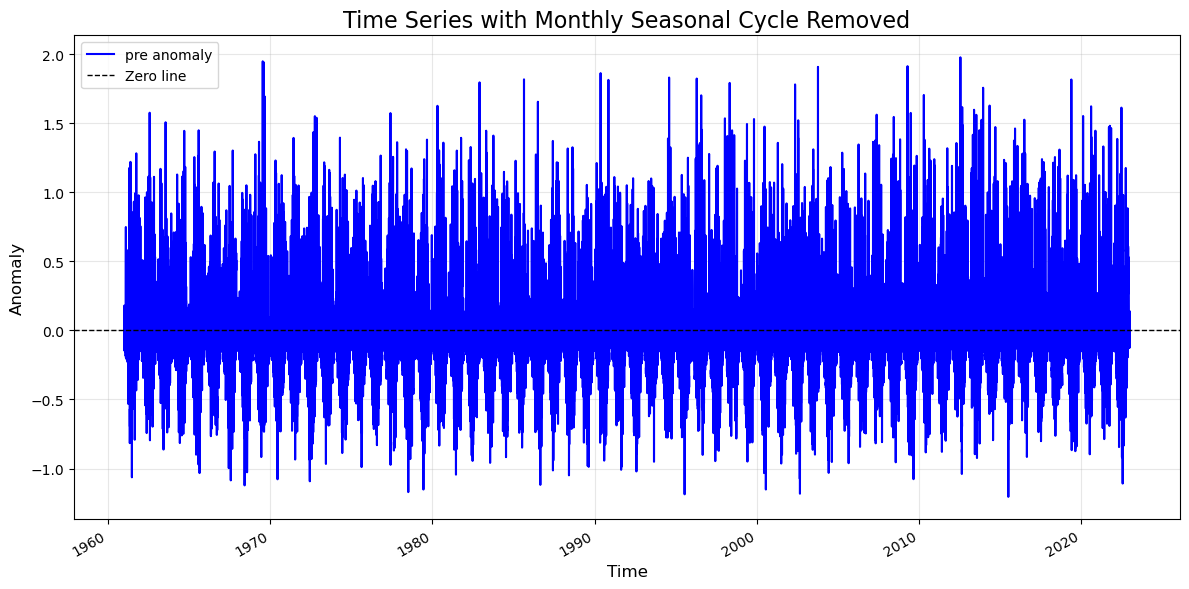

In [125]:
# 提取感兴趣的变量和时间

time = ds['time']  # 提取时间
# 提取降水数据和时间
precip = ds['pre']  # 降水变量
# 按月份计算气候学平均值（季节性分量）
climatology = precip.groupby('time.month').mean('time')

# 去除季节性循环
anomalies = precip.groupby('time.month') - climatology

# 计算全局平均值（如果需要）
global_anomaly = anomaly.mean(dim=['latitude', 'longitude'])  # 替换实际维度 

# 绘制时间序列
plt.figure(figsize=(12, 6))
global_anomaly.plot(label=f'{variable_name} anomaly', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero line')
plt.title('Time Series with Monthly Seasonal Cycle Removed', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Anomaly', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2732\1632443515.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=longitude_data, ax=axs[2, 0], palette='muted')


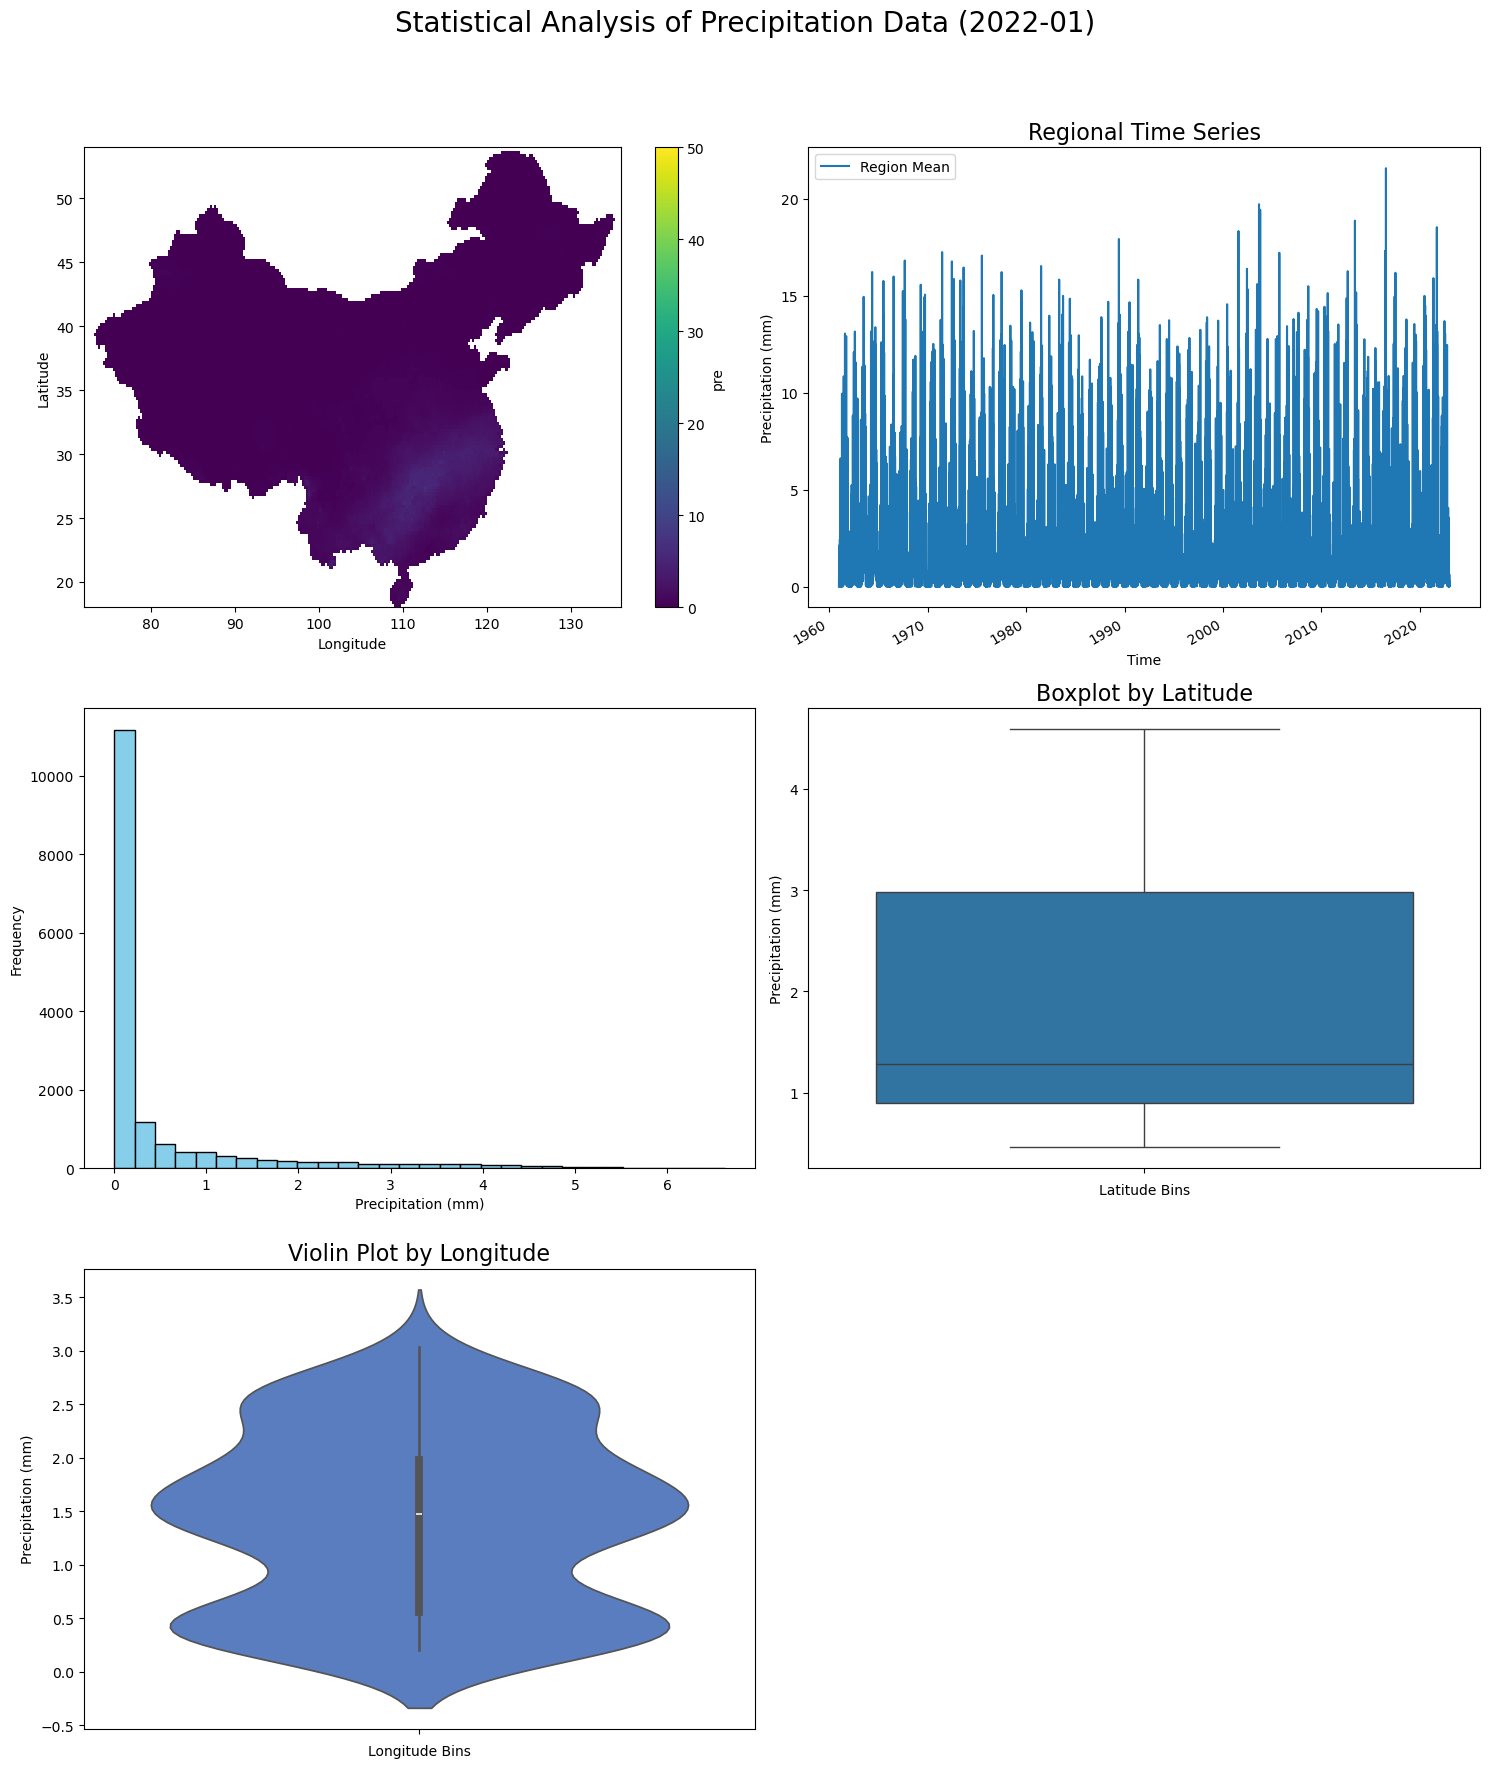

In [207]:
#第3题 3.2
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 加载 NetCDF 数据
file_path = "CHM_PRE_0.25dg_19612022.nc"  
ds = xr.open_dataset(file_path)

# 提取降水变量
precip = ds['pre']

# 数据清洗：去除无效值（假设无效值为 -99 或 NaN）
precip_cleaned = precip.where((precip != -99.9000015258789) & (~np.isnan(precip)), np.nan)

# 选择特定月份的数据
month_to_plot = '2022-01'  
precip_month = precip_cleaned.sel(time=slice(f'{month_to_plot}-01', f'{month_to_plot}-31'))

# 计算该月份的平均降水空间分布
precip_month_mean = precip_month.mean(dim='time')

# 设置图形
fig, axs = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle(f'Statistical Analysis of Precipitation Data ({month_to_plot})', fontsize=20)

# 1. 空间分布图
axs[0, 0].set_title('Spatial Distribution', fontsize=16)
precip_month_mean.plot(ax=axs[0, 0], cmap='viridis', vmin=0, vmax=50, add_colorbar=True)
axs[0, 0].set_xlabel('Longitude')
axs[0, 0].set_ylabel('Latitude')

# 2. 时间序列（某区域）
region_mean = precip_cleaned.sel(latitude=slice(30, 40), longitude=slice(100, 120)).mean(dim=['latitude', 'longitude'])
region_mean.plot(ax=axs[0, 1], label='Region Mean')
axs[0, 1].set_title('Regional Time Series', fontsize=16)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Precipitation (mm)')
axs[0, 1].legend()

# 3. 直方图
axs[1, 0].set_title('Histogram of Precipitation', fontsize=16)
precip_month_mean.plot.hist(ax=axs[1, 0], bins=30, color='skyblue', edgecolor='black')
axs[1, 0].set_xlabel('Precipitation (mm)')
axs[1, 0].set_ylabel('Frequency')

# 4. 箱线图（按纬度分布）
axs[1, 1].set_title('Boxplot by Latitude', fontsize=16)
latitude_data = precip_cleaned.groupby_bins('latitude', bins=10).mean(dim=['longitude', 'time']).values.flatten()
sns.boxplot(data=latitude_data, ax=axs[1, 1])
axs[1, 1].set_xlabel('Latitude Bins')
axs[1, 1].set_ylabel('Precipitation (mm)')

# 5. 小提琴图（按经度分布）
axs[2, 0].set_title('Violin Plot by Longitude', fontsize=16)
longitude_data = precip_cleaned.groupby_bins('longitude', bins=10).mean(dim=['latitude', 'time']).values.flatten()
sns.violinplot(data=longitude_data, ax=axs[2, 0], palette='muted')
axs[2, 0].set_xlabel('Longitude Bins')
axs[2, 0].set_ylabel('Precipitation (mm)')

# 移除多余子图框
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


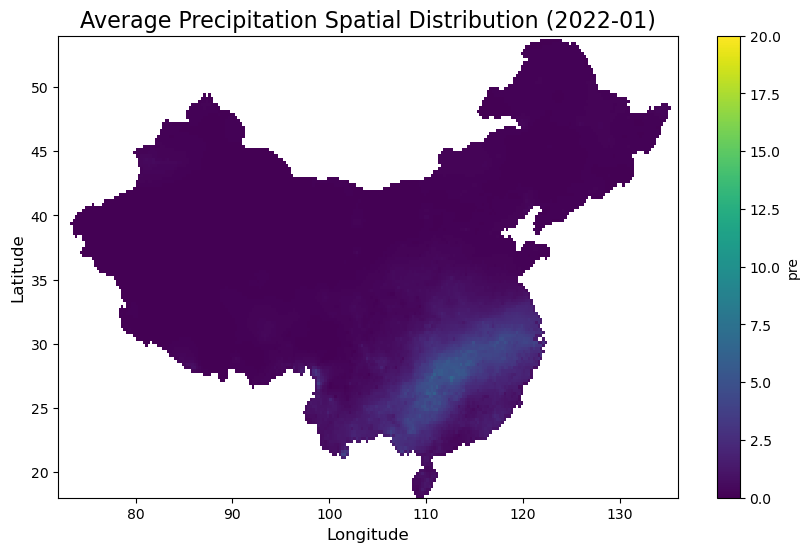

In [188]:
# 选择特定月份数据
month_to_plot = '2022-01'  # 替换为实际月份
precip_month = precip_cleaned.sel(time=slice(f'{month_to_plot}-01', f'{month_to_plot}-31'))

# 计算该月份的平均降水
precip_month_mean = precip_month.mean(dim='time')

# 绘制空间分布图（限制值范围以去除极值对图像的影响）
vmin = 0  # 最小值限制为 0（降水量不能为负）
vmax = 20  # 根据实际情况设置最大值范围
plt.figure(figsize=(10, 6))
precip_month_mean.plot(cmap='viridis', vmin=vmin, vmax=vmax)
plt.title(f'Average Precipitation Spatial Distribution ({month_to_plot})', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()